<a href="https://colab.research.google.com/github/ehsan1177/AlphaPose/blob/master/CSE525_CNN_Keras_Image_Classification_Dog_vs_Cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##Convolutional Neural Network (CNN) using KERAS & TESNSORFLOW

**Objective**: Dog vs Cat Classification Problem. Train the Model using sample Cat & Dog images and use it for prediction



In [0]:
%tensorflow_version 1.x

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import shutil

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dense, Flatten

from random import randint


Using TensorFlow backend.


#Importing Sample Dataset from Google Cloud

**Objective**: 
*   Import data set zip file
*   Unzip to /tmp
*   Move train & test data to appropriate directories










In [0]:
# Download zip file for the Dataset from Google
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-12-15 07:38:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   101MB/s    in 0.7s    

2019-12-15 07:38:56 (101 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
#Unzip the dataset to /tmp
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
os.listdir('/tmp/')
#os.listdir('/tmp/cats_and_dogs_filtered')

['train', 'cats_and_dogs_filtered.zip', 'cats_and_dogs_filtered', 'test']

In [0]:
#Create train & test directory
path = "/tmp/test"
os.mkdir(path)
path = '/tmp/train'
os.mkdir(path)
os.listdir('/tmp')

['train', 'cats_and_dogs_filtered.zip', 'cats_and_dogs_filtered', 'test']

In [0]:
path = '/tmp/cats_and_dogs_filtered/validation'
os.listdir(path)

['dogs', 'cats']

In [0]:
dest = '/tmp/test'

src = '/tmp/cats_and_dogs_filtered/validation/dogs'
src_files = os.listdir(src)
for file_name in tqdm( src_files ):
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)

src = '/tmp/cats_and_dogs_filtered/validation/cats'
src_files = os.listdir(src)
for file_name in tqdm( src_files ):
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)

100%|██████████| 500/500 [00:00<00:00, 6676.17it/s]


In [0]:
dest = '/tmp/train'

src = '/tmp/cats_and_dogs_filtered/train/dogs'
src_files = os.listdir(src)
for file_name in tqdm( src_files ):
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)


src = '/tmp/cats_and_dogs_filtered/train/cats'
src_files = os.listdir(src)
for file_name in tqdm( src_files ):
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)


In [0]:
path = '/tmp/test'
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print ("Test data = " + str(num_files))

path = '/tmp/train'
num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print ("Training data = " + str(num_files))

Test data = 1000
Training data = 2000


In [0]:
#Option A - Use Dataset from Local GDrive - too slow to import! 
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

#path=os.getcwd()+"/My Drive/IUB/201901 Autumn/CSE525 AI/Dataset/CatvsDog"
#os.listdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


#Defining Main Parameters & Data Setup for the Model

In [0]:
category = ["cat", "dog"]

EPOCHS                  = 40
IMGSIZE                 = 128
BATCH_SIZE              = 30
VERBOSE                 = 1
MODEL_NAME              = 'cnn_50epochs_imgsize128'
OPTIMIZER               = 'adam'  
TRAINING_DIR            = "/tmp/train"
TEST_DIR                = "/tmp/test"

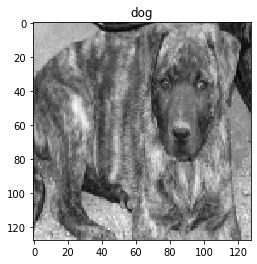

In [0]:
val = randint(0, 2000)

for img in os.listdir(TRAINING_DIR)[val:]:
    img_path = os.path.join(TRAINING_DIR, img)
    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
    plt.imshow(img_arr, cmap='gray')
    plt.title(img.split('.')[0])
    break

In [0]:
def create_training_data(path):
    X = []
    y = []
    for img in tqdm(os.listdir(path)):
        
        img_path = os.path.join(path, img)
        img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        dimensions = img_arr.shape

        if dimensions[0] >= 128 and dimensions[1] >= 128:
          #print(dimensions)
          img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
          img_arr = img_arr / 255.0 
          animal = np.where(img.split('.')[0] == 'dog', 1, 0)
        
          X.append(img_arr)
          y.append(animal)
    
    X = np.array(X).reshape(-1, IMGSIZE, IMGSIZE, 1) 
    y = np.array(y)
    
    return X, y        

In [0]:
X, y = create_training_data(TRAINING_DIR)

print(f"features shape {X.shape}.\nlabel shape {y.shape}.")

100%|██████████| 2000/2000 [00:02<00:00, 779.65it/s]


features shape (1957, 128, 128, 1).
label shape (1957,).


In [0]:
#One hot array conversion
y = to_categorical(y, 2) 
print(f"features shape {X.shape}.\nlabel shape {y.shape}.")

features shape (1957, 128, 128, 1).
label shape (1957, 2).


In [0]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)
train_gen = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = train_datagen.flow(X_test, y_test, batch_size=BATCH_SIZE)

In [0]:
#CNN Model
model = Sequential()

# Conv2D (filters, kernel_size, activation function)
model.add(Conv2D(32, (3, 3), border_mode='same', activation='relu', input_shape=X.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  

model.add(Conv2D(128, (3, 3), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (3, 3), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128,..., padding="same")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", padding="same")`


#Running the Model

In [0]:
history = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=1/3)

Train on 1304 samples, validate on 653 samples
Epoch 1/40
1304/1304 [==============================] - 65s 50ms/step - loss: 0.7081 - acc: 0.5211 - val_loss: 0.6933 - val_acc: 0.4824
Epoch 2/40
1304/1304 [==============================] - 63s 48ms/step - loss: 0.6930 - acc: 0.5081 - val_loss: 0.6937 - val_acc: 0.4824
Epoch 3/40
1304/1304 [==============================] - 63s 49ms/step - loss: 0.6941 - acc: 0.5088 - val_loss: 0.6935 - val_acc: 0.4824
Epoch 4/40
1304/1304 [==============================] - 63s 48ms/step - loss: 0.6930 - acc: 0.5042 - val_loss: 0.6936 - val_acc: 0.4824
Epoch 5/40
1304/1304 [==============================] - 63s 48ms/step - loss: 0.6915 - acc: 0.5341 - val_loss: 0.6948 - val_acc: 0.4824
Epoch 6/40
1304/1304 [==============================] - 63s 48ms/step - loss: 0.6928 - acc: 0.5104 - val_loss: 0.6951 - val_acc: 0.4824
Epoch 7/40
1304/1304 [==============================] - 63s 49ms/step - loss: 0.6903 - acc: 0.5353 - val_loss: 0.6987 - val_acc: 0.4824
E

In [0]:
savePath='/tmp/'
model.save_weights(savePath + "CATSvsDOGS_model.h5")
model.save(savePath + 'CNN_CAT.model')

In [0]:
#Plot the Loss & Accuracy Graphs
train_acc = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

653/653 [==============================] - 7s 11ms/step


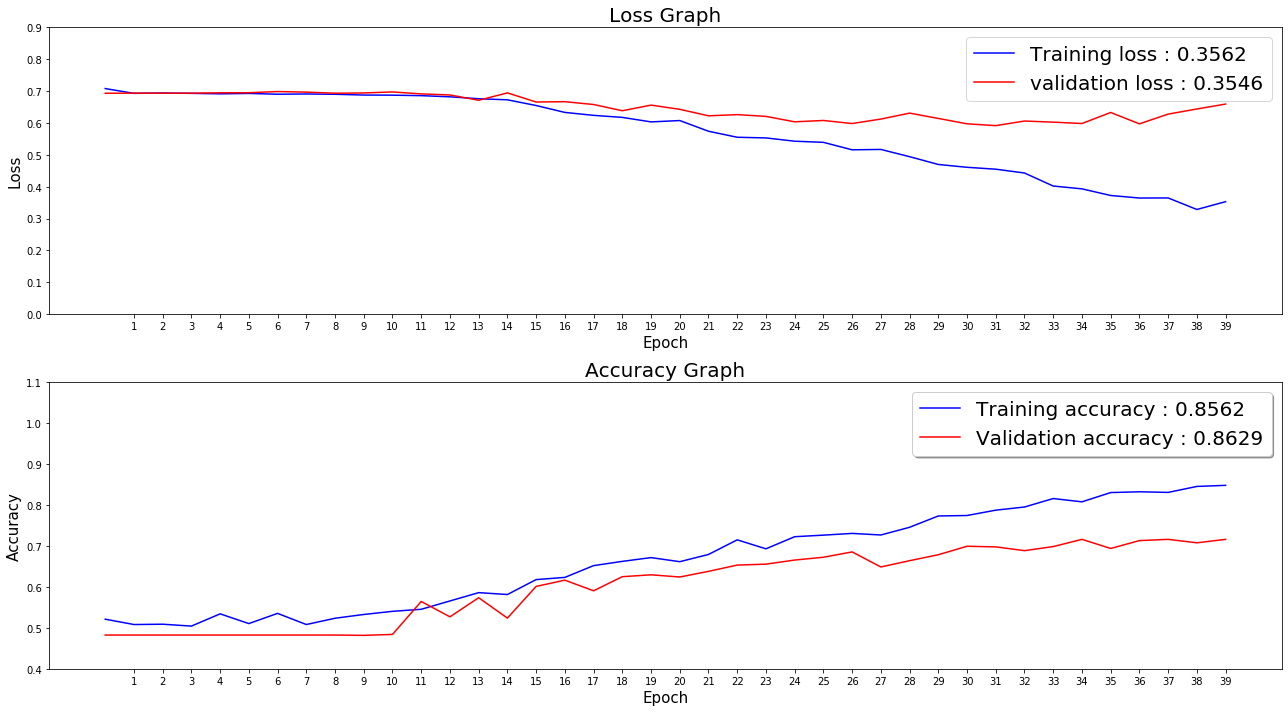

In [0]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
ax1.plot(history.history['loss'], color='b', label="Training loss : {:0.4f}".format(train_acc[0]))
ax1.plot(history.history['val_loss'], color='r', label="validation loss : {:0.4f}".format(test_acc[0]))
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1., 0.1))
ax1.set_xlabel('Epoch',fontsize = 15)
ax1.set_ylabel('Loss',fontsize = 15)
ax1.set_title('Loss Graph',fontsize = 20)
ax1.legend(fontsize = 20)

ax2.plot(history.history['acc'], color='b', label="Training accuracy : {0:.4f}".format(train_acc[1]))
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy : {0:.4f}".format(test_acc[1]))
ax2.set_xticks(np.arange(1, EPOCHS, 1))
ax2.set_yticks(np.arange(0.4, 1.2, 0.1))
ax2.set_xlabel('Epoch',fontsize = 15)
ax2.set_ylabel('Accuracy',fontsize = 15)
ax2.set_title('Accuracy Graph',fontsize = 20)

legend = plt.legend(loc='best', shadow=True, fontsize = 20)
plt.tight_layout()
plt.show()

#Prediction / Validation

In [0]:
#Predictions from the Test image dataset
im_test = []
c = 0
for img in os.listdir(TEST_DIR)[:50]:
    c = c + 1
    img_path = os.path.join(TEST_DIR, img)
    img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_arr = cv2.resize(img_arr, (IMGSIZE, IMGSIZE))
    img_arr = img_arr / 255.0
    im_test.append(img_arr)
im_test = np.array(im_test).reshape(-1, IMGSIZE, IMGSIZE, 1)
im_pred = model.predict(im_test)

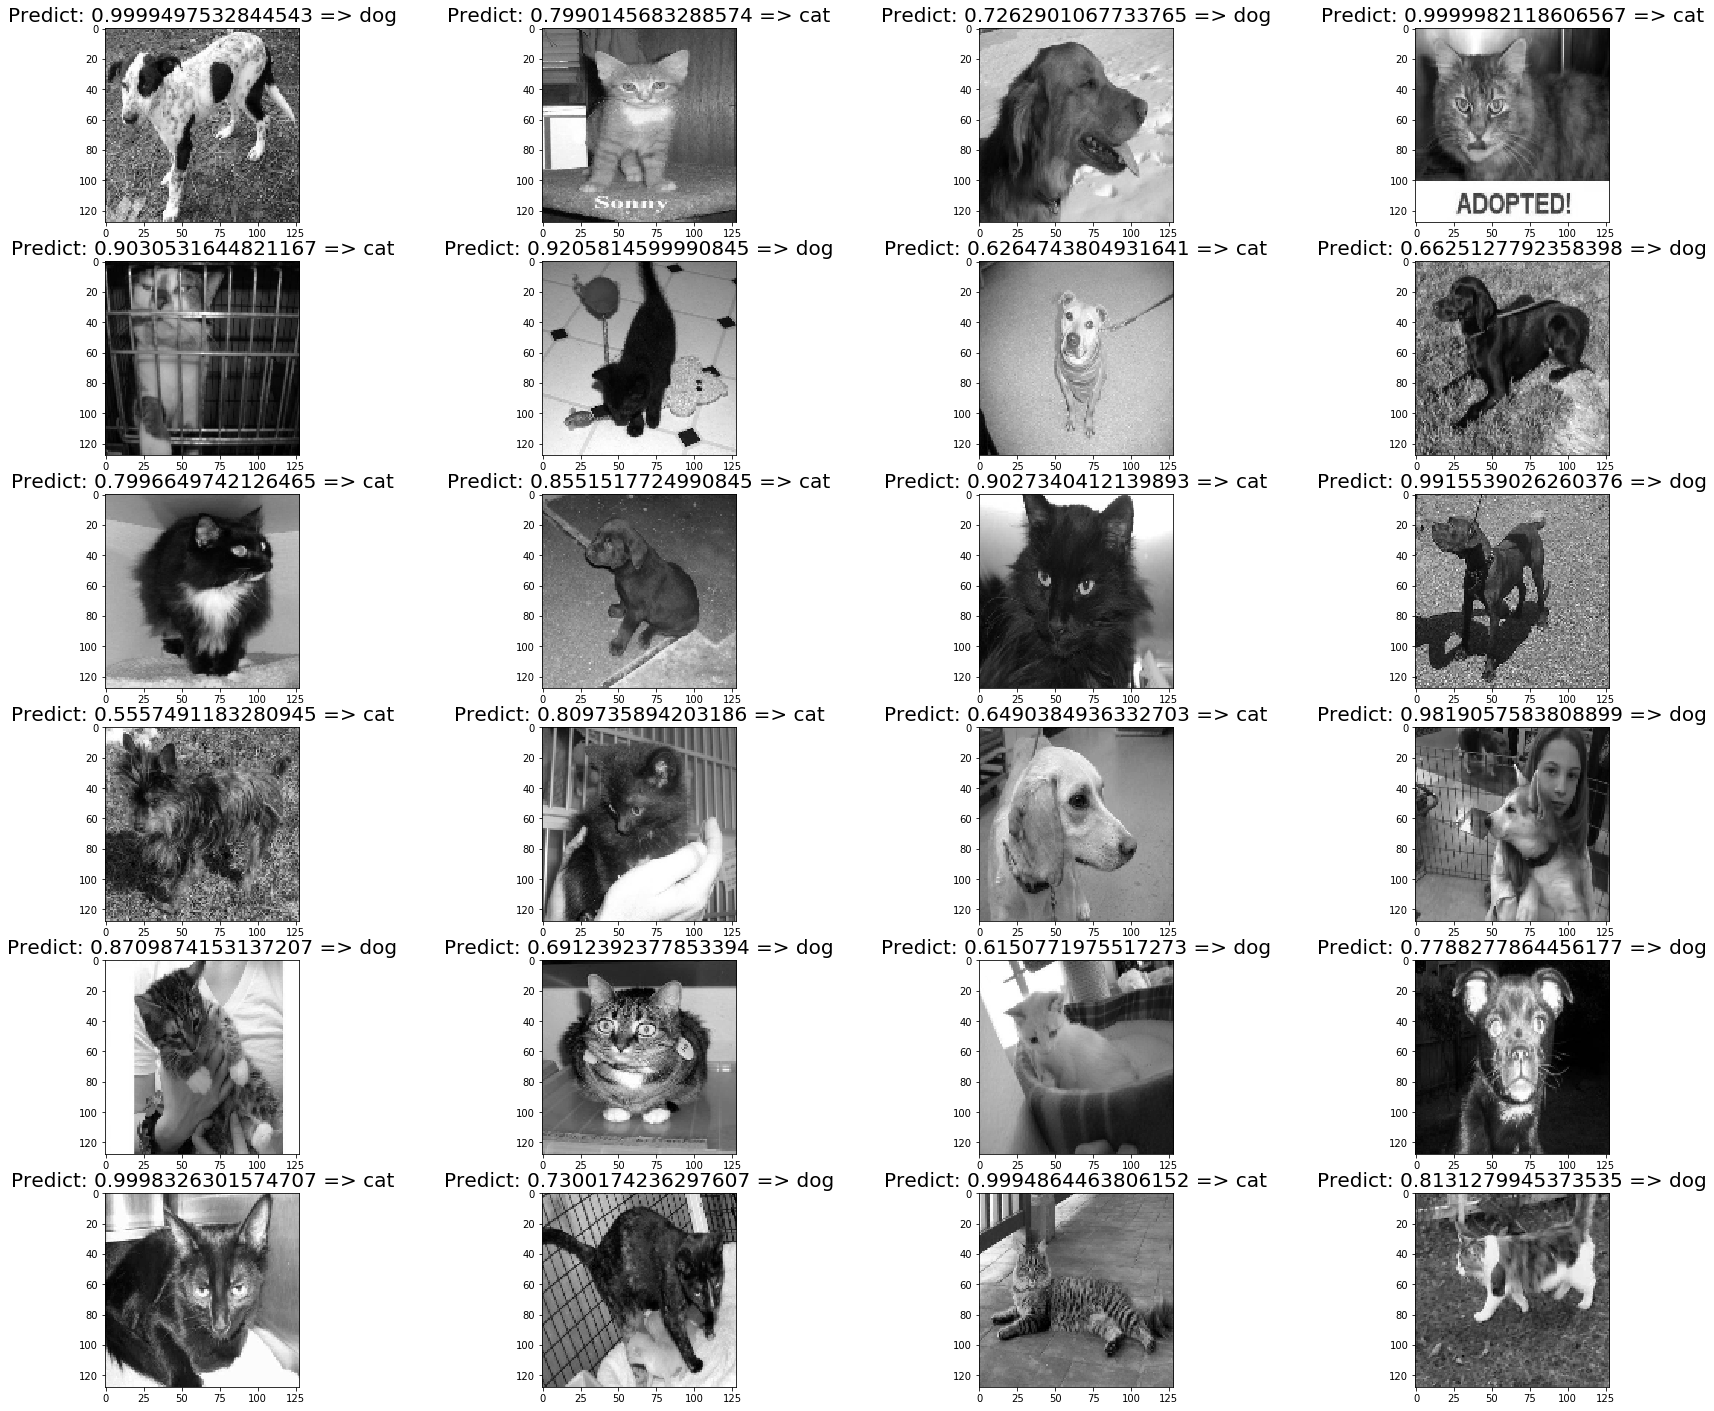

In [0]:
fig , ax = plt.subplots(6, 4, figsize=(30, 25))
for i, axis in enumerate(ax.flat):
    axis.imshow(im_test[i].reshape(128, 128), cmap='gray')
    #axis.set(title=f'{im_pred[i].max()} => {category[im_pred[i].argmax()]}')
    axis.set_title(f'Predict: {im_pred[i].max()} => {category[im_pred[i].argmax()]}', fontsize=20)

#Model Summary

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)      